In [2]:
import torch
import torchvision

from torch import nn 
from torchvision import transforms
from torchinfo import summary

import engine
import data_setup

from pathlib import Path


c:\Users\jmhimara\miniconda3\envs\learning\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular/data_setup.py", "data_setup.py")
urllib.request.urlretrieve("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular/engine.py", "engine.py")
urllib.request.urlretrieve("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular/model_builder.py", "model_builder.py")
urllib.request.urlretrieve("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular/predictions.py", "predictions.py")
urllib.request.urlretrieve("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular/train.py", "train.py")

urllib.request.urlretrieve("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/going_modular/going_modular/utils.py", "utils.py")

('utils.py', <http.client.HTTPMessage at 0x1b80a38ced0>)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
image_path = Path("data/pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:

# Create datasets and dataloaders 
# use same transform as the model 

# first do it manually
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), 
    transforms.ToTensor(), 
    normalize
])

train_dl, test_dl, class_names = data_setup.create_dataloaders(train_dir ,test_dir, manual_transform, 32)



In [7]:
train_dl, test_dl, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1b80a39a850>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# automatic transforms. 

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT ## best available weights. 
auto_transforms= weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dl, test_dl, class_names = data_setup.create_dataloaders(train_dir ,test_dir, auto_transforms, 32)


In [10]:
# import model 

model = torchvision.models.efficientnet_b0(weights = weights)

In [11]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [12]:
summary(model, input_size=(1,3,224, 224), col_names = ["input_size", "output_size", "num_params", "trainable"]
        , row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

In [13]:
## Freeze the base layers of the model 

for param in model.features.parameters():
    param.requires_grad = False 

summary(model, input_size=(1,3,224, 224), col_names = ["input_size", "output_size", "num_params", "trainable"]
        , row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

In [14]:
# update the classifier 

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), 
    nn.Linear(in_features=1280, out_features=3)
)

In [15]:
# train 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

results = engine.train(model, train_dl, test_dl, optimizer, loss_fn, 5, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0691 | train_acc: 0.3789 | test_loss: 0.8456 | test_acc: 0.7727
Epoch: 2 | train_loss: 0.9424 | train_acc: 0.5586 | test_loss: 0.7932 | test_acc: 0.7633
Epoch: 3 | train_loss: 0.7576 | train_acc: 0.8359 | test_loss: 0.7135 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7282 | train_acc: 0.7695 | test_loss: 0.6246 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.6879 | train_acc: 0.7734 | test_loss: 0.5494 | test_acc: 0.8352


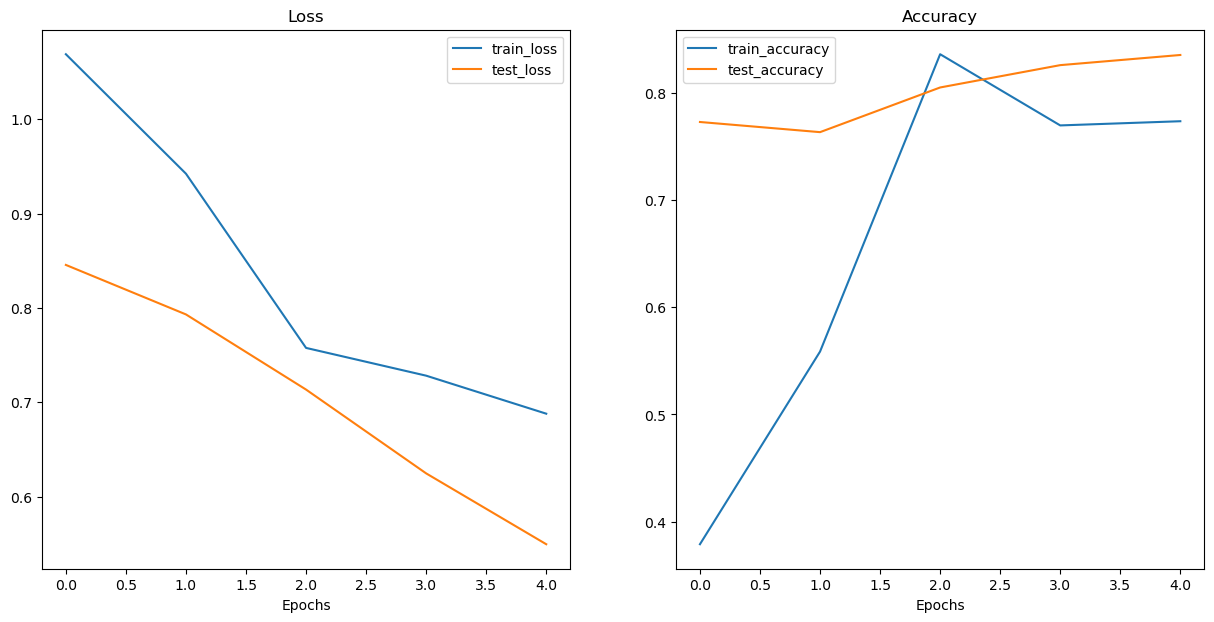

In [16]:
from helpers import plot_loss_curves

plot_loss_curves(results)

In [25]:
# make a function to prepare test images
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt

def pred_plot_image(
        model: nn.Module, 
        image_path: str, 
        class_names: List[str], 
        image_size: Tuple[int, int] = (224,224),
        transform: torchvision.transforms = None, 
):
    img = Image.open(image_path)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    if transform is not None:
        image_transform = transform
    else: 
        image_transform = transforms.Compose([
            transforms.Resize(size=(224,224)), 
            transforms.ToTensor(), 
            normalize
        ])

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0) ## model expects image in batches

        target_image_pred = model(transformed_image)

    image_prob = torch.softmax(target_image_pred, dim=1)

    image_label = torch.argmax(image_prob, dim = 1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[image_label]}, Prob: {image_prob.max():.4f}")
    plt.axis(False)

In [23]:
# get a random image path and 3 images
import random

path_list = list(Path(test_dir).glob("*/*.jpg"))
test_sample = random.sample(path_list, k=3)

test_sample

[WindowsPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/steak/1285886.jpg')]

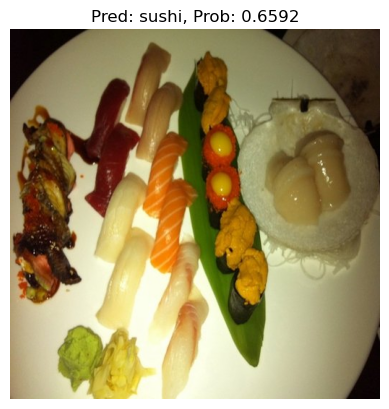

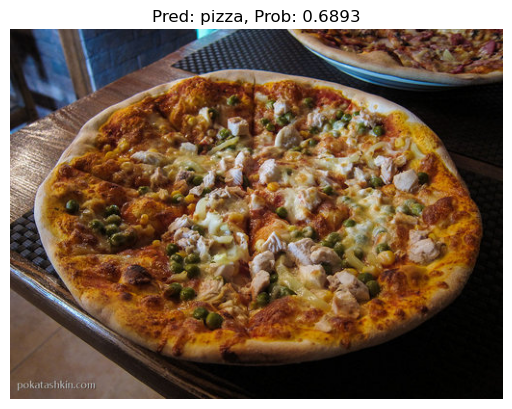

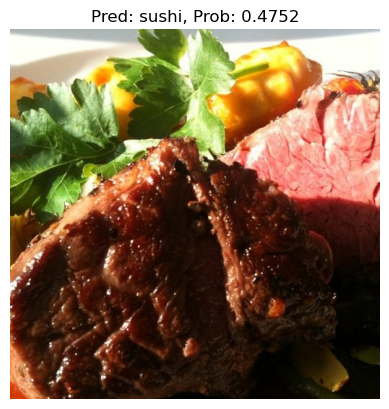

In [26]:
for image_path in test_sample: 
    pred_plot_image(model=model, 
                    image_path=image_path, 
                    class_names=class_names)